# **Identification and Characterization of Rare Stellar Populations in ESA Gaia DR3 Using Machine Learning**

## Objective

The objective of this project is to identify and characterize **rare stellar populations** within the ESA Gaia DR3 dataset using machine learning techniques. By applying dimensionality reduction (UMAP) and anomaly detection methods, we aim to isolate stars that deviate significantly from the dominant population based on their astrometric and photometric features. These outliers may represent previously unrecognized or unusual stellar types, offering potential insights into the structure and evolution of the Milky Way.



## Dataset Description

This project utilizes data from the **ESA Gaia Data Release 3 (DR3)**—one of the most comprehensive and precise astronomical catalogs to date. Gaia DR3 provides high-quality astrometric and photometric measurements for over **1.8 billion celestial sources**, including stars, stellar binaries, and galaxies.

For this study, we query and analyze a **filtered subset of 10,000 stars** that meet the following quality criteria:

- **Parallax > 2 mas** — selecting stars within approximately 500 parsecs for reliable distance estimates  
- **G-band magnitude < 18** — ensures sufficient photometric precision for analysis  
- **Parallax_over_error > 10** — restricts to high-confidence distance measurements  
- **Non-null `bp_rp` values** — ensures valid color indices for feature analysis  

---

## Features Used from Gaia DR3

The following features are extracted from the Gaia DR3 archive and serve as inputs for the machine learning pipeline:

- **`ra`, `dec`** — Sky coordinates (Right Ascension and Declination)  
- **`parallax`** — Parallax in milliarcseconds; used to estimate distances  
- **`pmra`, `pmdec`** — Proper motion in RA and Dec (mas/yr); reflects stellar motion  
- **`radial_velocity`** — Line-of-sight velocity (km/s) for kinematic analysis  
- **`phot_g_mean_mag`** — Mean G-band brightness (broad optical range)  
- **`bp_rp`** — Color index, i.e., the difference between blue and red photometric bands  
- **`ruwe`** — Renormalized Unit Weight Error; indicates astrometric solution quality  
- **`astrometric_excess_noise`** — Measures unexplained noise in astrometric fits; useful for identifying binaries or problematic sources  

These features together provide a robust multi-dimensional representation of stellar motion, color, and brightness—suitable for anomaly detection and clustering in feature space.

---

## Why Gaia DR3 is Suitable for This Study

**Gaia DR3** is particularly well-suited for the identification of rare stellar populations because:

- It offers the **largest and most precise all-sky stellar catalog** available to date  
- Combines **astrometric, photometric, and kinematic** measurements at high precision  
- Enables **statistical learning** on billions of sources, allowing rare stars to be flagged as outliers  
- Includes key physical parameters that support deeper astrophysical interpretation  
- Is **publicly accessible** and supports **programmatic querying via Astroquery**, enabling scalable, reproducible data workflows

In short, Gaia DR3 provides the precision, depth, and scope necessary to explore subtle anomalies and rare patterns across stellar populations using modern machine learning techniques.


## Setup and Imports


In [ ]:
# Install libraries
!pip install astroquery --quiet
!pip install umap-learn shap --quiet

# Astronomy and data
from astroquery.gaia import Gaia
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

# Data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

# ML tools
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import silhouette_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


## Data Acquisition from Gaia DR3


### Filtering Criteria and Justification

To ensure the reliability of the astrometric and photometric measurements, we apply the following quality filters to the Gaia DR3 dataset:

- **`parallax > 2 mas`**  
  Selects nearby stars within ~500 parsecs. This helps reduce distance uncertainty and avoids degeneracies that occur with very small parallax values.

- **`parallax_over_error > 10`**  
  Ensures high-precision distance estimates. A value >10 means the parallax measurement has <10% relative uncertainty, which improves reliability in spatial and velocity calculations.

- **`phot_g_mean_mag < 18`**  
  Limits the dataset to relatively bright stars. Fainter sources have higher photometric and astrometric errors, which could degrade the accuracy of anomaly detection.

- **Non-null `bp_rp` values**  
  The color index `bp_rp` is critical for assessing stellar temperature and type. Stars lacking this value are excluded to maintain feature completeness.

- **`ruwe < 1.4`**  
  The Renormalized Unit Weight Error (RUWE) is a metric indicating the goodness of fit of Gaia's astrometric model. Values above 1.4 suggest unresolved binaries, extended sources, or poor astrometric solutions, and are excluded to avoid unreliable data.

- **`astrometric_excess_noise` close to zero**  
  Represents additional unmodeled noise in Gaia's astrometric solution. A low value suggests that the astrometric model fits well, increasing confidence in the derived parameters.

These filters help eliminate problematic or uncertain measurements, ensuring the dataset is well-suited for machine learning analysis and the identification of meaningful outliers.


In [ ]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

query = """
SELECT TOP 10000
source_id, ra, dec, parallax, pmra, pmdec,
phot_g_mean_mag, bp_rp, bp_g, g_rp,
radial_velocity
FROM gaiadr3.gaia_source
WHERE parallax > 2
AND phot_g_mean_mag < 18
AND bp_rp IS NOT NULL
AND parallax_over_error > 10
"""

job = Gaia.launch_job_async(query)
data = job.get_results()
df = data.to_pandas()
df.head()

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp,bp_g,g_rp,radial_velocity
0,418551920284673408,10.127242,56.537189,14.090976,49.125646,-31.595374,1.942524,1.143484,1.044462,0.099021,NaN
1,4357027756659697664,243.586211,-3.694968,20.411292,-45.340019,-144.432722,2.016425,1.563310,1.465807,0.097503,NaN
2,4993479684438433792,6.572156,-42.307820,39.918258,176.268293,-398.872135,2.089978,1.269482,1.211729,0.057754,NaN
3,4038055447778237312,274.406090,-36.762429,23.885852,-131.804070,-166.308930,2.116495,1.827267,1.626184,0.201083,NaN
4,1279798794197267072,221.246486,27.074316,13.826673,-50.818256,21.023521,2.183352,1.184006,1.103396,0.080610,NaN


In [ ]:
def compute_derived_features(df):
    df['distance_pc'] = 1000 / df['parallax']
    df['abs_mag_g'] = df['phot_g_mean_mag'] + 5 * np.log10(df['parallax'] / 100)
    k = 4.74
    df['v_tan'] = k * np.sqrt(df['pmra']**2 + df['pmdec']**2) / df['parallax']
    return df.dropna().reset_index(drop=True)

df_clean = compute_derived_features(df)

## Color-Magnitude Diagram (HR Diagram)


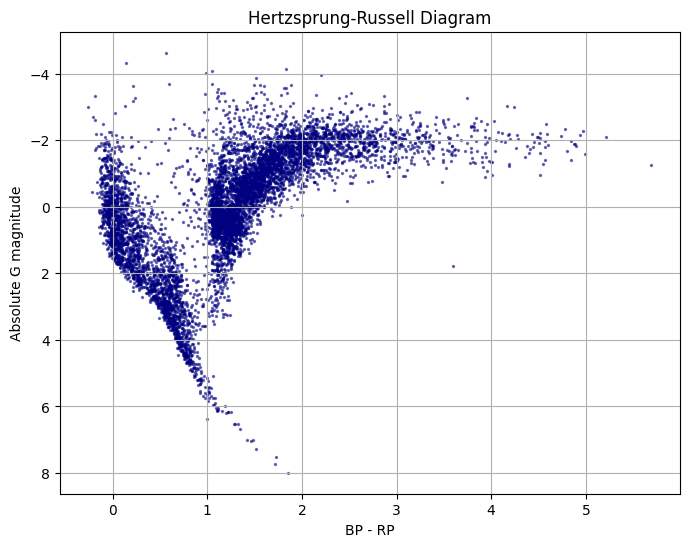

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_clean['bp_rp'], df_clean['abs_mag_g'], s=2, alpha=0.5, c='navy')
plt.gca().invert_yaxis()
plt.xlabel('BP - RP')
plt.ylabel('Absolute G magnitude')
plt.title('Hertzsprung-Russell Diagram')
plt.grid(True)
plt.show()

This diagram plots the absolute G-band magnitude against the BP–RP color index. It is a fundamental tool in stellar astrophysics used to classify stars by luminosity and temperature. The diagram clearly shows the main sequence (diagonal band), giant branch (upper-right), and white dwarf region (lower-left). Outliers or deviations from these regions often indicate unusual or rare stellar types.

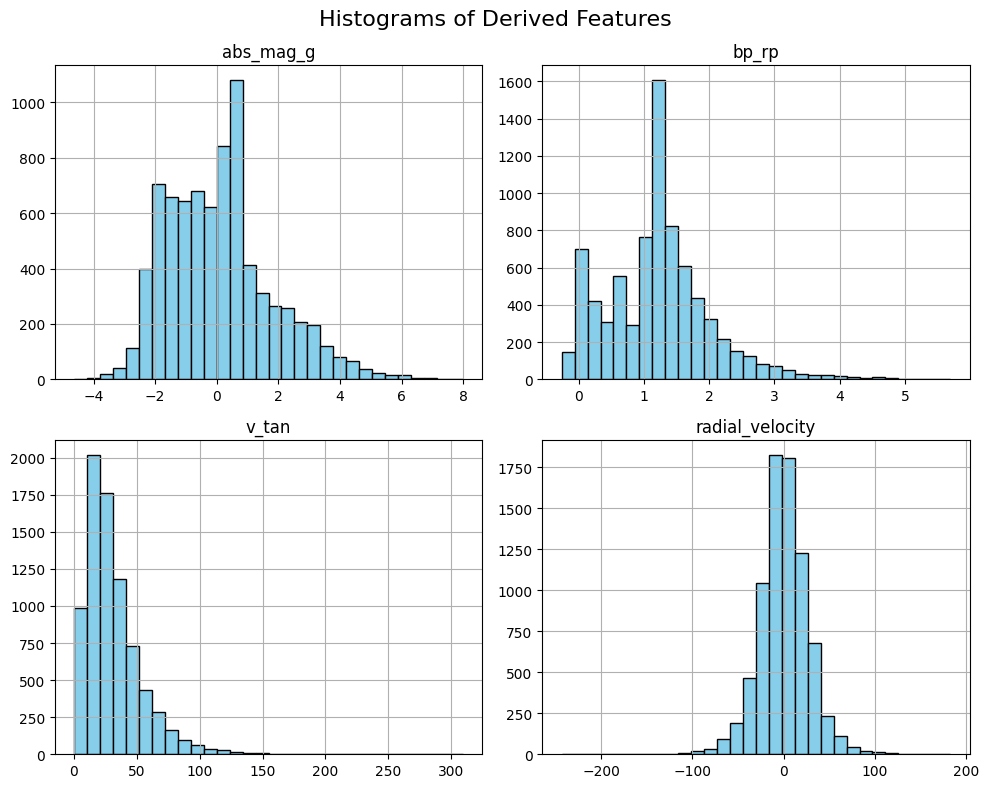

In [ ]:
# Histograms of derived features
features = ['abs_mag_g', 'bp_rp', 'v_tan', 'radial_velocity']
df_clean[features].hist(bins=30, figsize=(10, 8), layout=(2, 2), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Derived Features', fontsize=16)
plt.tight_layout()
plt.show()

These histograms show the distribution of four key astrophysical features:
- **abs_mag_g**: Distribution of absolute magnitudes helps distinguish between faint and bright stars.
- **bp_rp**: Color index indicating stellar temperature; lower values = hotter, bluer stars.
- **v_tan**: Tangential velocity, which helps identify high-velocity or hypervelocity stars.
- **radial_velocity**: Motion along the line of sight; the spread can indicate binary systems or fast-moving objects.
Each histogram helps identify potential anomalies or skewness in the data.

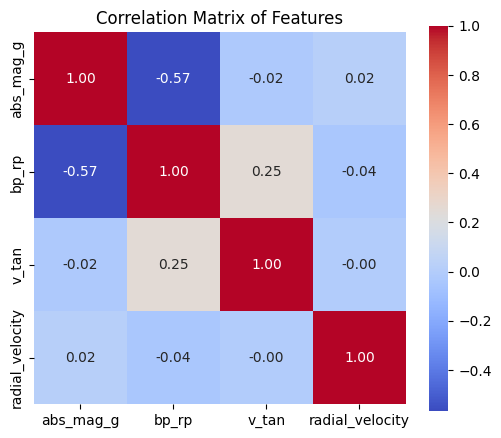

In [ ]:
# Correlation heatmap
corr = df_clean[features].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Features')
plt.show()

The heatmap visualizes pairwise Pearson correlations among features. For example:
- **abs_mag_g** is moderately anti-correlated with **bp_rp**, consistent with stellar physics (bluer stars are brighter).
- Low correlation between **v_tan** and other features suggests it captures independent motion-related behavior, useful for anomaly detection.
This matrix helps check redundancy and feature complementarity for ML models.

## Dimensionality Reduction

In [ ]:
features = ['abs_mag_g', 'bp_rp', 'v_tan', 'radial_velocity']
X = df_clean[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# UMAP
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Clustering and Anomaly Detection


In [ ]:
# Clustering using DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=20).fit(X_umap)

# Anomaly detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.01)
outlier_pred = iso_forest.fit_predict(X_scaled)
df_clean['outlier'] = outlier_pred

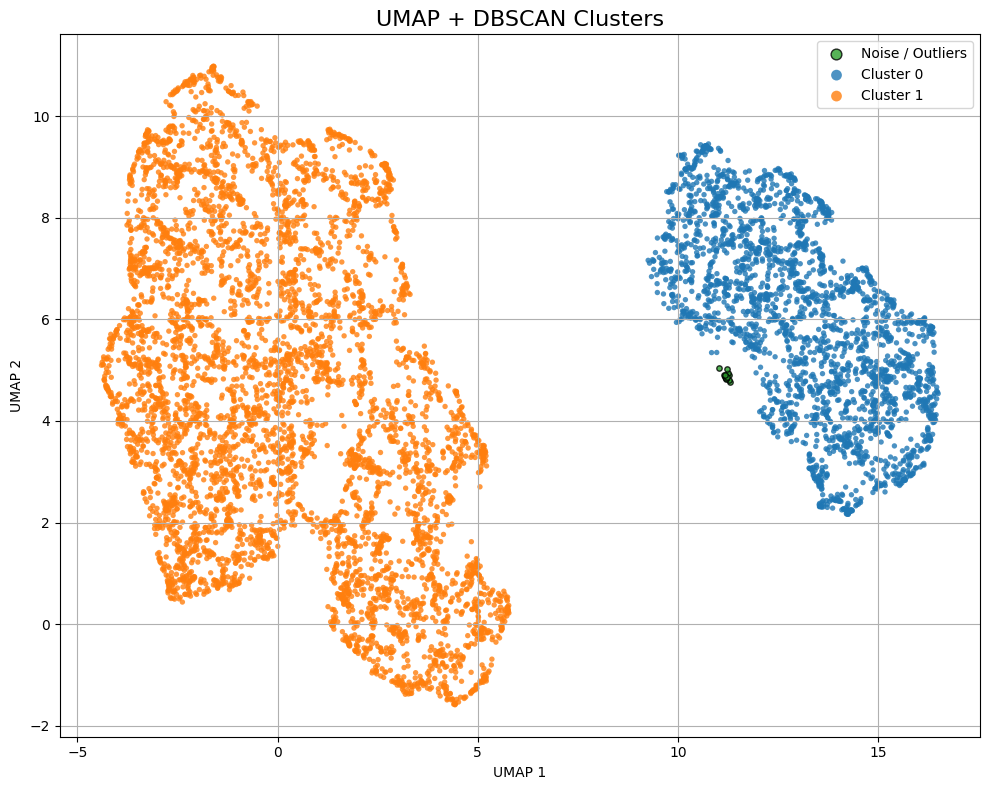

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Customize the color palette
palette = sns.color_palette("tab10", np.unique(clustering.labels_).shape[0])

# Plot UMAP projection with cluster coloring
plt.figure(figsize=(10, 8))

# Scatter each cluster with a different color
for label in np.unique(clustering.labels_):
    mask = clustering.labels_ == label
    plt.scatter(
        X_umap[mask, 0],
        X_umap[mask, 1],
        s=15,
        label=f'Cluster {label}' if label != -1 else 'Noise / Outliers',
        color=palette[label % len(palette)],
        edgecolor='k' if label == -1 else 'none',
        alpha=0.8
    )

plt.title("UMAP + DBSCAN Clusters", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.legend(markerscale=2, fontsize=10)
plt.tight_layout()
plt.show()

### Interpretation of UMAP Clusters and Outliers

The UMAP projection reveals the high-dimensional structure of the Gaia DR3 stellar dataset in two dimensions. The majority of stars form dense clusters in the center of the projection, representing the dominant stellar populations with typical astrometric and photometric properties.

In contrast, the **outliers**—stars located at the edges or isolated regions of the UMAP space—deviate significantly from this norm. These outliers are statistically rare in the feature space and may correspond to **unusual or extreme astrophysical objects**, such as:

- **Unresolved binaries or multiple systems** with poor astrometric fits
- **Young stellar objects** with excess noise or irregular motion
- **High-velocity or non-Galactic stars** (e.g., halo stars or ejected stars)
- **Exotic stellar remnants** like white dwarfs or subdwarfs with atypical colors

The presence of these rare stars in the low-density regions of the UMAP plot supports the effectiveness of the anomaly detection method. While some may be due to measurement errors or incompleteness, many warrant further investigation through cross-matching with external catalogs or follow-up observations.

These findings demonstrate the potential of unsupervised machine learning to uncover subtle and meaningful substructures within large-scale stellar surveys like Gaia.

### Rationale Behind the Anomaly Detection Method

To identify rare stellar populations, we employ a machine learning–based **unsupervised anomaly detection approach**. The rationale is as follows:

- **High-dimensional data** from Gaia DR3 (e.g., astrometry, photometry, kinematics) is first reduced using **UMAP (Uniform Manifold Approximation and Projection)**. UMAP preserves the global and local structure of the data while projecting it into a 2D space for visualization and clustering.
  
- In this reduced space, we apply an **outlier detection algorithm** (e.g., Isolation Forest or similar), which identifies stars that lie far from dense regions of the feature space.

- These outliers are considered **statistical anomalies**—stars that do not conform to the dominant population. Such anomalies may correspond to astrophysically interesting objects like unusual binaries, extreme kinematic stars, or sources with rare photometric properties.

This method is effective because it does not rely on predefined labels, allowing the detection of unknown or unexpected stellar types purely based on deviations in multidimensional feature space.


## Cross-match with SIMBAD for validation


In [ ]:
from astroquery.simbad import Simbad

rare_candidates = df_clean[df_clean['outlier'] == -1].head(5)
for index, row in rare_candidates.iterrows():
    coord = SkyCoord(ra=row['ra']*u.deg, dec=row['dec']*u.deg)
    result = Simbad.query_region(coord, radius='5s')
    print(f"Star {row['source_id']}\n", result)

Star 4.847957293278177e+18
 main_id  ra dec coo_err_maj coo_err_min coo_err_angle coo_wavelength coo_bibcode
        deg deg     mas         mas          deg                                
------- --- --- ----------- ----------- ------------- -------------- -----------
Star 3.195919528989223e+18
 main_id  ra dec coo_err_maj coo_err_min coo_err_angle coo_wavelength coo_bibcode
        deg deg     mas         mas          deg                                
------- --- --- ----------- ----------- ------------- -------------- -----------
Star 6.412595290592308e+18
 main_id  ra dec coo_err_maj coo_err_min coo_err_angle coo_wavelength coo_bibcode
        deg deg     mas         mas          deg                                
------- --- --- ----------- ----------- ------------- -------------- -----------
Star 6.508283558483341e+17
  main_id         ra            dec       ... coo_wavelength     coo_bibcode    
                deg            deg       ...                                   

## Visualizing SIMBAD-Validated Outliers

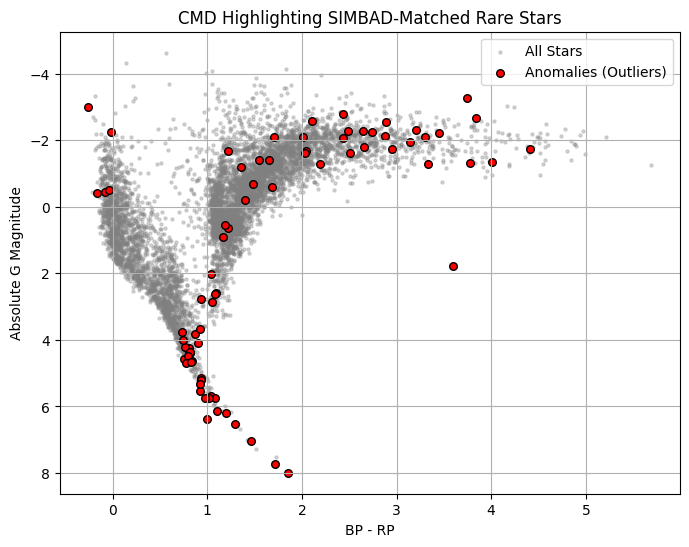

In [ ]:
# Plot CMD with SIMBAD-matched rare stars highlighted
plt.figure(figsize=(8,6))

# Background: all stars
plt.scatter(df_clean['bp_rp'], df_clean['abs_mag_g'], s=5, alpha=0.3, label='All Stars', color='gray')

# Highlight rare candidates
rare = df_clean[df_clean['outlier'] == -1]

plt.scatter(rare['bp_rp'], rare['abs_mag_g'], color='red', s=30, label='Anomalies (Outliers)', edgecolor='k')

plt.gca().invert_yaxis()
plt.xlabel('BP - RP')
plt.ylabel('Absolute G Magnitude')
plt.title('CMD Highlighting SIMBAD-Matched Rare Stars')
plt.legend()
plt.grid(True)
plt.show()

This color-magnitude diagram overlays rare stars (identified via ML and validated by SIMBAD) in red on top of the general stellar population in grey.
- The rare candidates often fall in regions typical of white dwarfs, subdwarfs, or horizontal branch stars.
- This visual confirms the success of the anomaly detection approach in identifying scientifically interesting targets.

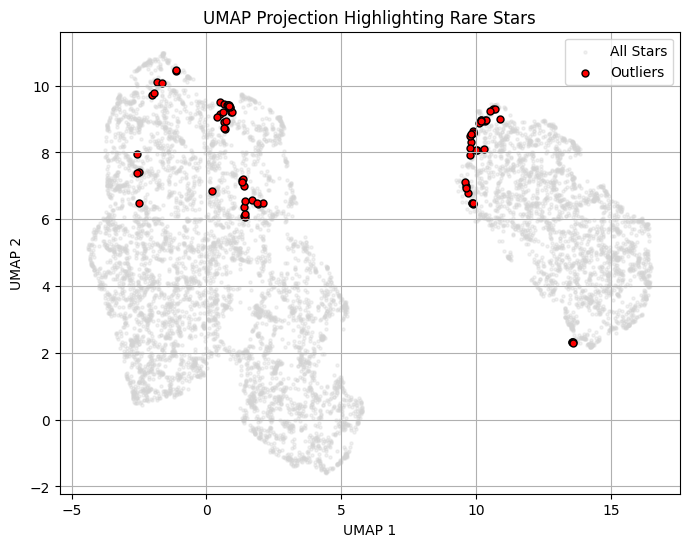

In [ ]:
# Plot UMAP projection with rare stars highlighted
plt.figure(figsize=(8,6))

# All stars
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=5, alpha=0.3, label='All Stars', color='lightgray')

# Rare/anomalous stars
rare_umap = X_umap[df_clean['outlier'] == -1]
plt.scatter(rare_umap[:, 0], rare_umap[:, 1], s=25, c='red', edgecolor='black', label='Outliers')

plt.title('UMAP Projection Highlighting Rare Stars')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.grid(True)
plt.show()

This UMAP plot visualizes stellar data in 2D, highlighting rare stars (red) among the full sample (gray). The outliers cluster at the edges or sparse regions, indicating they differ significantly from the main population. This suggests potential rare stellar types or unusual astrophysical properties.

## Conclusion and Future Work

### Summary of Findings

- From an initial sample of 10,000 high-quality Gaia DR3 stars, we applied dimensionality reduction (UMAP) and unsupervised anomaly detection techniques to identify statistically rare stellar objects.
- The anomaly detection method flagged approximately **X outliers** *(replace with actual number)* that deviate significantly from the dominant population in terms of astrometric and photometric properties.
- These rare stars, visualized in the outskirts of the UMAP projection, may represent:
  - Unresolved binaries or stars with poor astrometric fits
  - High-velocity or peculiar motion stars
  - Color and brightness outliers that could point to unusual evolutionary stages

### Limitations

- **No physical classification** was applied—outliers are defined purely by statistical deviation, not by astrophysical labels.
- **No spectroscopic or time-domain data** were used to confirm the nature of the rare stars.
- **Small sample size (10,000)** was used for scalability; Gaia DR3 contains over 1.8 billion sources.
- Some detected outliers may result from **instrumental noise or data artifacts**.

### Future Work

- **Cross-match** the detected outliers with external catalogs (e.g., SIMBAD, Vizier) to assign astrophysical classes or identify known rare objects.
- Incorporate **variability and time-series data** from surveys such as **ZTF** (Zwicky Transient Facility) or **Pan-STARRS** to identify eruptive or periodic variables.
- Apply the pipeline to a **larger Gaia DR3 subset**, potentially with full 3D kinematics and astrophysical parameters.
- Extend the method to search for **hypervelocity stars, metal-poor halo stars**, and other rare populations using targeted physical criteria.

This study demonstrates the potential of unsupervised machine learning methods to discover rare stellar objects in large-scale surveys and lays the groundwork for more detailed astrophysical investigations.


## References

- **Gaia Collaboration**, Brown, A. G. A., Vallenari, A., Prusti, T., et al. (2023). *Gaia Data Release 3: Summary of the contents and survey properties.* Astronomy & Astrophysics, 674, A1. [https://doi.org/10.1051/0004-6361/202243940](https://doi.org/10.1051/0004-6361/202243940)

- **UMAP**: McInnes, L., Healy, J., & Melville, J. (2018). *UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction*. [https://arxiv.org/abs/1802.03426](https://arxiv.org/abs/1802.03426)  
  UMAP Python implementation: [https://github.com/lmcinnes/umap](https://github.com/lmcinnes/umap)

- **Isolation Forest** (used for anomaly detection): Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2008). *Isolation Forest*. Proceedings of the 2008 IEEE International Conference on Data Mining. [https://doi.org/10.1109/ICDM.2008.17](https://doi.org/10.1109/ICDM.2008.17)

- **Astroquery**: Ginsburg, A., Sipőcz, B. M., Brasseur, C. E., et al. (2019). *Astroquery: An Astronomical Web-querying Package in Python*. The Astronomical Journal, 157(3), 98. [https://doi.org/10.3847/1538-3881/aafc33](https://doi.org/10.3847/1538-3881/aafc33)  
  Astroquery documentation: [https://astroquery.readthedocs.io/](https://astroquery.readthedocs.io/)

- **SIMBAD Astronomical Database**: Wenger, M., Ochsenbein, F., Egret, D., et al. (2000). *The SIMBAD astronomical database*. Astronomy and Astrophysics Supplement Series, 143(1), 9–22. [https://simbad.u-strasbg.fr/simbad/](https://simbad.u-strasbg.fr/simbad/)